# Submission 2 Membuat Model Machine Learning dengan Data Time Series

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [61]:
dataset = pd.read_csv('/content/AMZN_2006-01-01_to_2018-01-01.csv')
dataset

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN
1,2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN
2,2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN
3,2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN
4,2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN
...,...,...,...,...,...,...,...
3014,2017-12-22,1172.08,1174.62,1167.83,1168.36,1585054,AMZN
3015,2017-12-26,1168.36,1178.32,1160.55,1176.76,2005187,AMZN
3016,2017-12-27,1179.91,1187.29,1175.61,1182.26,1867208,AMZN
3017,2017-12-28,1189.00,1190.10,1184.38,1186.10,1841676,AMZN


In [62]:
dataset.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64

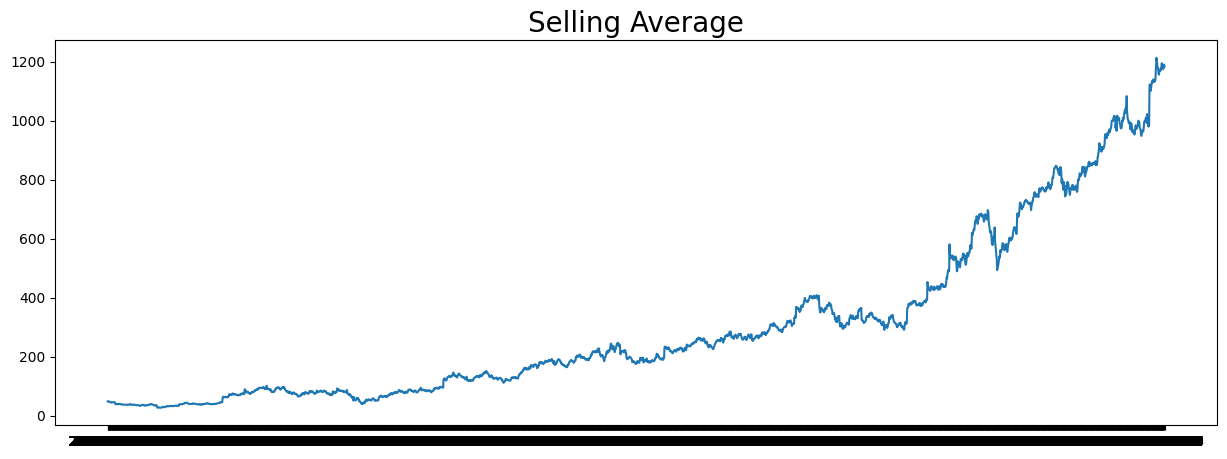

In [63]:
dates = dataset['Date'].values
selling = dataset['High'].values

plt.figure(figsize=(15,5))
plt.plot(dates, selling)
plt.title('Selling Average',
          fontsize=20);

In [64]:
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset = dataset.set_index('Date')

In [65]:
selling = selling.reshape(-1,1)
selling

array([[  47.85],
       [  47.73],
       [  48.2 ],
       ...,
       [1187.29],
       [1190.1 ],
       [1184.  ]])

In [66]:
scaler = MinMaxScaler()
selling = scaler.fit_transform(selling)

In [67]:
X_train, X_test, y_train, y_test = train_test_split(selling, dates,
                                                    test_size=0.2,
                                                    shuffle=False)

In [68]:
print('Total Data Train : ',len(X_train))
print('Total Data Validation : ',len(X_test))

Total Data Train :  2415
Total Data Validation :  604


In [69]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [70]:
train_set = windowed_dataset(X_train, window_size=60, batch_size=64, shuffle_buffer=1000)
test_set  = windowed_dataset(X_test, window_size=128, batch_size=64, shuffle_buffer=1000)

In [71]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(50, return_sequences=True, input_shape = [None, 1]),
  tf.keras.layers.LSTM(50),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [72]:
threshold_mae = (selling.max() - selling.min()) * 10/100
print(threshold_mae)

0.1


In [77]:
class myCallback(tf.keras.callbacks.Callback):
  def __init__(self, min_epochs=10):
    self.min_epochs = min_epochs
    self.epochs_passed = 0

  def on_epoch_end(self, epoch, logs={}):
    self.epochs_passed += 1

    if self.epochs_passed >= self.min_epochs and logs.get('mae') < threshold_mae:
      print(f"MAE < 10% after {self.epochs_passed} epochs.")
      self.model.stop_training = True

callbacks = myCallback(min_epochs=20)

In [78]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set,
                    epochs=100,
                    validation_data=test_set,
                    verbose=2,
                    callbacks=[callbacks])

Epoch 1/100
37/37 - 10s - loss: 0.0069 - mae: 0.0982 - val_loss: 0.0965 - val_mae: 0.4162 - 10s/epoch - 276ms/step
Epoch 2/100
37/37 - 1s - loss: 0.0070 - mae: 0.0990 - val_loss: 0.0984 - val_mae: 0.4208 - 1s/epoch - 29ms/step
Epoch 3/100
37/37 - 1s - loss: 0.0068 - mae: 0.0984 - val_loss: 0.0971 - val_mae: 0.4177 - 786ms/epoch - 21ms/step
Epoch 4/100
37/37 - 1s - loss: 0.0068 - mae: 0.0984 - val_loss: 0.0975 - val_mae: 0.4185 - 754ms/epoch - 20ms/step
Epoch 5/100
37/37 - 1s - loss: 0.0067 - mae: 0.0977 - val_loss: 0.0987 - val_mae: 0.4213 - 749ms/epoch - 20ms/step
Epoch 6/100
37/37 - 1s - loss: 0.0067 - mae: 0.0978 - val_loss: 0.0960 - val_mae: 0.4150 - 919ms/epoch - 25ms/step
Epoch 7/100
37/37 - 1s - loss: 0.0068 - mae: 0.0988 - val_loss: 0.0986 - val_mae: 0.4212 - 784ms/epoch - 21ms/step
Epoch 8/100
37/37 - 1s - loss: 0.0066 - mae: 0.0975 - val_loss: 0.0990 - val_mae: 0.4222 - 933ms/epoch - 25ms/step
Epoch 9/100
37/37 - 1s - loss: 0.0065 - mae: 0.0958 - val_loss: 0.0973 - val_mae: 0

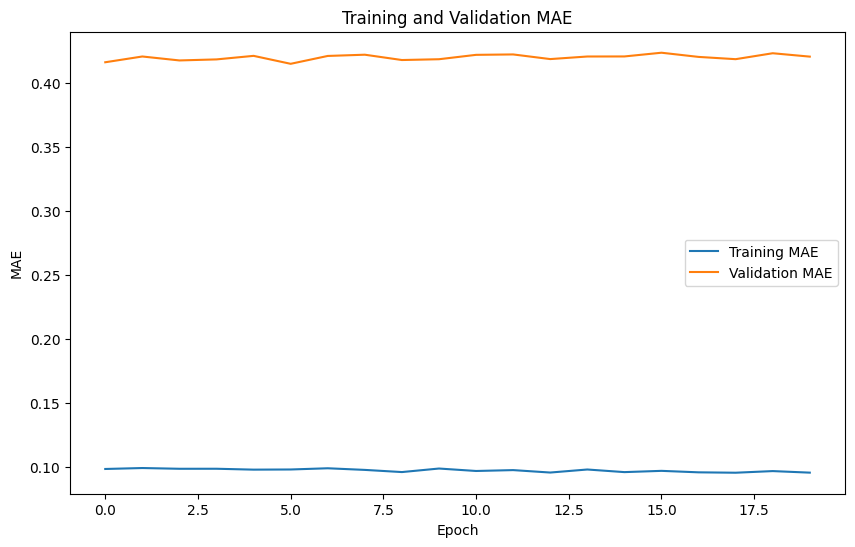

In [79]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

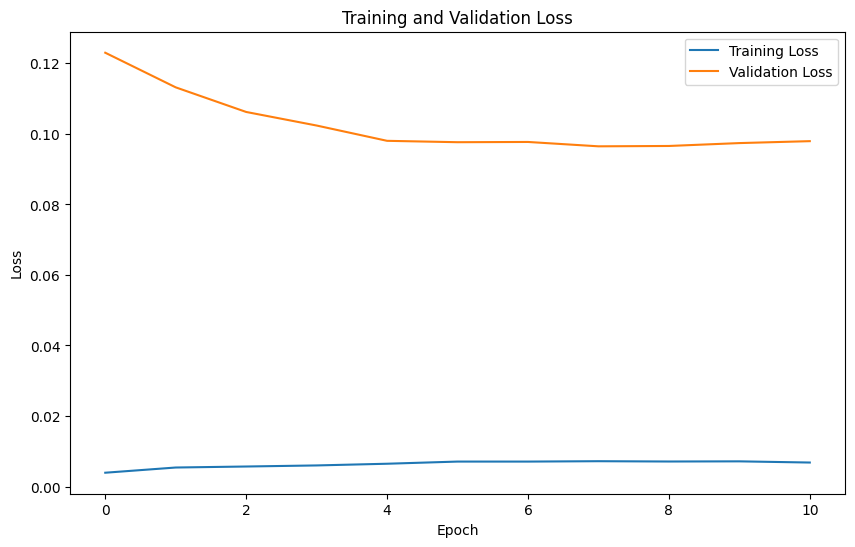

In [76]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()